In [ ]:
!pip -q install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Fetch dataset (UCI id=1 is Abalone)
abalone = fetch_ucirepo(id=1)

X = abalone.data.features.copy()
y = abalone.data.targets.copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.head())

X shape: (4177, 8)
y shape: (4177, 1)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


,Rings
0,15
1,7
2,9
3,10
4,7


In [ ]:
# Create an "Age" target in years (Age = Rings + 1.5)
# y is typically a dataframe with a single column "Rings"
rings_col = y.columns[0]
y_age = y[rings_col].astype(float) + 1.5

print("Rings column:", rings_col)
print("Age (years) summary:")
display(y_age.describe())

Rings column: Rings
Age (years) summary:


,Rings
count,4177.000000
mean,11.433684
std,3.224169
min,2.500000
25%,9.500000
50%,10.500000
75%,12.500000
max,30.500000


In [ ]:
# Quick sanity checks
print("Missing values in X:\n", X.isna().sum())
print("\nMissing values in y_age:", y_age.isna().sum())

# If any missing values are there, you could drop the rows with missing values:
# mask = X.notna().all(axis=1) & y_age.notna()
# X, y_age = X.loc[mask].reset_index(drop=True), y_age.loc[mask].reset_index(drop=True)

Missing values in X:
 Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
dtype: int64

Missing values in y_age: 0


In [ ]:
#Training the raw data and splitting it

X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size=0.2, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (3341, 8) Test: (836, 8)


## Preprocessing + KNN model
- One-hot encode `Sex`
- Standardize numeric features (important for KNN distances)
- Train `KNeighborsRegressor`


In [ ]:
# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False))
        ]), num_cols),
    ]
)

model = KNeighborsRegressor()

pipe = TransformedTargetRegressor(regressor=Pipeline
    (steps=[("pre", preprocess), ("knn", model)]),
    func=np.log1p,
    inverse_func=np.expm1
)

Categorical columns: ['Sex']
Numeric columns: ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']


In [ ]:
#prefix is 'regressor__knn__' because of the TransformedTargetRegressor wrapper

pipe.set_params(regressor__knn__n_neighbors=5)
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"Baseline (k=5) MAE:  {mae:.3f} years")
print(f"Baseline (k=5) RMSE: {rmse:.3f} years")
print(f"Baseline (k=5) R2:   {r2:.3f}")

Baseline (k=5) MAE:  1.603 years
Baseline (k=5) RMSE: 2.310 years
Baseline (k=5) R2:   0.507


In [ ]:
#prefix is 'regressor__knn__' because of the TransformedTargetRegressor wrapper
param_grid = {
    "regressor__knn__n_neighbors": [18, 20, 28, 30],
    "regressor__knn__weights": ["uniform", "distance"],
    "regressor__knn__p": [1] # 1=Manhattan, 2=Euclidean
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best Parameters found:", search.best_params_)


Best Parameters found: {'regressor__knn__n_neighbors': 18, 'regressor__knn__p': 1, 'regressor__knn__weights': 'distance'}


In [ ]:
# Evaluate best model on test set
best_model = search.best_estimator_
pred_best = best_model.predict(X_test)

mae = mean_absolute_error(y_test, pred_best)
rmse = np.sqrt(mean_squared_error(y_test, pred_best))
r2 = r2_score(y_test, pred_best)

print(f"Test MAE:  {mae:.3f} years")
print(f"Test RMSE: {rmse:.3f} years")
print(f"Test R2:   {r2:.3f}")

Test MAE:  1.536 years
Test RMSE: 2.285 years
Test R2:   0.518


# CV MAE vs k (for the best weight+p setting per k)

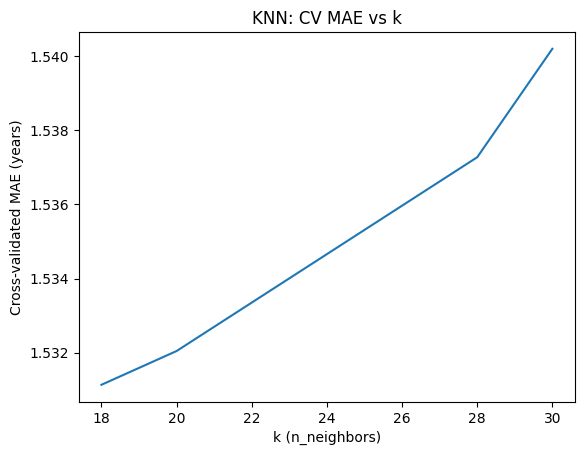

Best k by this summary: 18


In [ ]:
results = pd.DataFrame(search.cv_results_)

# Convert to positive MAE
results["mae"] = -results["mean_test_score"]

# Summarize: for each k, take the best MAE across other params
k_summary = results.groupby("param_regressor__knn__n_neighbors")["mae"].min().reset_index()
k_summary = k_summary.rename(columns={"param_regressor__knn__n_neighbors": "k"})

best_row = k_summary.loc[k_summary["mae"].idxmin()]
best_k = int(best_row["k"])

plt.figure()
plt.plot(k_summary["k"], k_summary["mae"])
plt.xlabel("k (n_neighbors)")
plt.ylabel("Cross-validated MAE (years)")
plt.title("KNN: CV MAE vs k")
plt.show()

print("Best k by this summary:", best_k)

## Plot: Predicted vs actual age

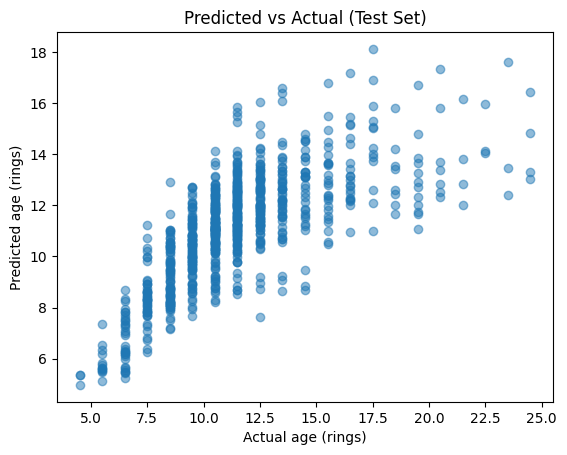

,actual_age,pred_age
0,10.5,12.413860
1,9.5,10.512394
2,17.5,15.296942
3,10.5,11.794750
4,15.5,13.969009
5,12.5,10.579389
6,8.5,10.189107
7,7.5,9.988434
8,8.5,8.007984
9,11.5,11.588960


In [ ]:
plt.figure()
plt.scatter(y_test, pred_best, alpha=0.5)
plt.xlabel("Actual age (rings)")
plt.ylabel("Predicted age (rings)")
plt.title("Predicted vs Actual (Test Set)")
plt.show()

# Optional: print a few examples
comparison = pd.DataFrame({"actual_age": y_test.values, "pred_age": pred_best})
display(comparison.head(10))


In [ ]:
def within_tolerance(y_true, y_pred, tol_years=1.0):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) <= tol_years)

# Example:
acc_1yr = within_tolerance(y_test, pred_best, tol_years=1.0)
acc_2yr = within_tolerance(y_test, pred_best, tol_years=2.0)
acc_3yr = within_tolerance(y_test, pred_best, tol_years=3.0)
acc_4yr = within_tolerance(y_test, pred_best, tol_years=4.0)
acc_5yr = within_tolerance(y_test, pred_best, tol_years=5.0)
print(f"Within ±1 year: {acc_1yr*100:.2f}%")
print(f"Within ±2 years: {acc_2yr*100:.2f}%")
print(f"Within ±3 years: {acc_3yr*100:.2f}%")
print(f"Within ±4 years: {acc_4yr*100:.2f}%")
print(f"Within ±5 years: {acc_5yr*100:.2f}%")

Within ±1 year: 48.21%
Within ±2 years: 77.39%
Within ±3 years: 87.80%
Within ±4 years: 92.46%
Within ±5 years: 95.10%


Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2)
base KNN model,1.5357,2.2849,0.5177,4820.57%,7739.23%


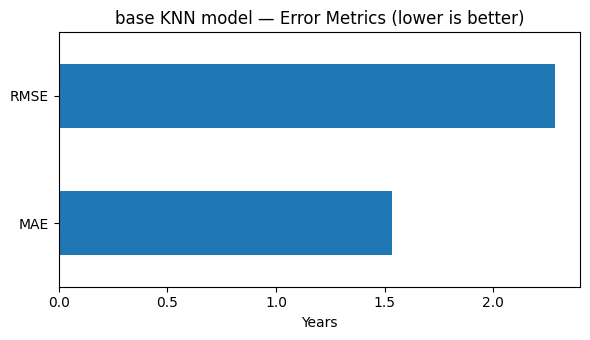

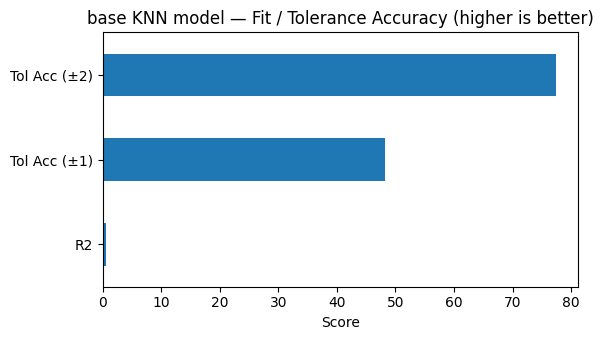

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def knn_report(y_true, y_pred, label="KNN"):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    tol1 = np.mean(np.abs(y_true - y_pred) <= 1.0) * 100  # ±1 ring (or ±1 year if your target is age)
    tol2 = np.mean(np.abs(y_true - y_pred) <= 2.0) * 100

    report = pd.DataFrame([{
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Tolerance Acc (±1)": tol1,
        "Tolerance Acc (±2)": tol2,
    }]).round(4)

    return report

def pretty_report(report: pd.DataFrame, title="Model Evaluation"):
    # ---------- 1) Styled table ----------
    styled = (
        report.copy()
        .style
        .format({
            "MAE": "{:.4f}",
            "RMSE": "{:.4f}",
            "R2": "{:.4f}",
            "Tolerance Acc (±1)": "{:.2%}",
            "Tolerance Acc (±2)": "{:.2%}",
        })
        .set_caption(title)
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "td", "props": [("padding", "8px 12px")]},
        ])
        .background_gradient(subset=["R2", "Tolerance Acc (±1)", "Tolerance Acc (±2)"])
        .background_gradient(subset=["MAE", "RMSE"], cmap="Reds_r")  # lower is better
    )
    display(styled)

    # ---------- 2) Charts ----------
    row = report.iloc[0]

    # Error metrics chart (lower is better)
    err = pd.Series({"MAE": row["MAE"], "RMSE": row["RMSE"]})
    plt.figure(figsize=(6, 3.5))
    err.sort_values().plot(kind="barh")
    plt.title(f"{row['Model']} — Error Metrics (lower is better)")
    plt.xlabel("Years")
    plt.tight_layout()
    plt.show()

    # Quality/accuracy chart (higher is better)
    qual = pd.Series({
        "R2": row["R2"],
        "Tol Acc (±1)": row["Tolerance Acc (±1)"],
        "Tol Acc (±2)": row["Tolerance Acc (±2)"],
    })
    plt.figure(figsize=(6, 3.5))
    qual.sort_values().plot(kind="barh")
    plt.title(f"{row['Model']} — Fit / Tolerance Accuracy (higher is better)")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

report = knn_report(y_test, pred_best, label="base KNN model")
pretty_report(report, title="KNN Results")

In [ ]:
y_test_rings = np.asarray(y_test) - 1.5
pred_rings = np.asarray(pred) - 1.5
knn_report(y_test_rings, pred_rings, label="KNN (tuned) [rings]")

,Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2)
0,KNN (tuned) [rings],1.6029,2.3098,0.5072,45.5742,74.0431


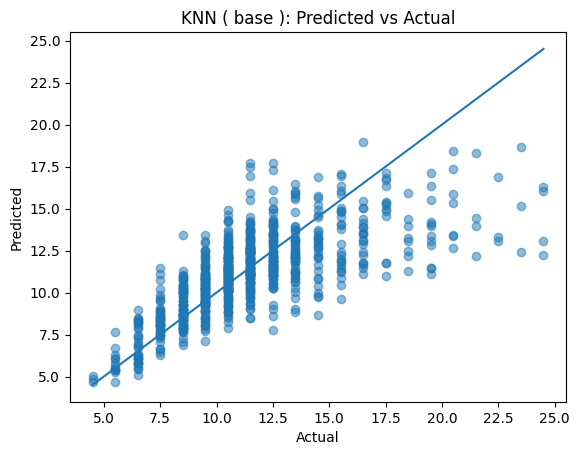

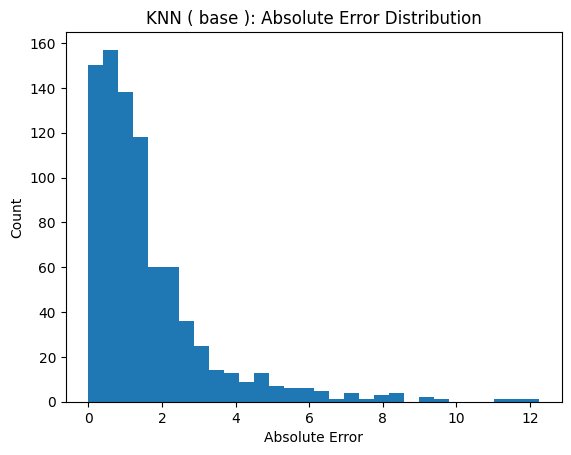

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_knn_diagnostics(y_true, y_pred, title_prefix="KNN"):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    resid = y_true - y_pred

    # Predicted vs Actual
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title_prefix}: Predicted vs Actual")
    plt.show()

    # Absolute error histogram
    plt.figure()
    plt.hist(np.abs(resid), bins=30)
    plt.xlabel("Absolute Error")
    plt.ylabel("Count")
    plt.title(f"{title_prefix}: Absolute Error Distribution")
    plt.show()

plot_knn_diagnostics(y_test, pred, title_prefix="KNN ( base )")


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold

def poly_knn_regression(X_train, y_train, X_test, y_test, knn_report,
                        k_list=(3,5,7,9,11,13,15),
                        degrees=(1,2,3),
                        cv_splits=5):

    pipe = Pipeline([
        ("poly", PolynomialFeatures(include_bias=False)),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor())
    ])

    param_grid = {
        "poly__degree": list(degrees),
        "knn__n_neighbors": list(k_list),
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2]  # 1=Manhattan, 2=Euclidean
    }

    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=cv,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    pred = gs.predict(X_test)
    report = knn_report(y_test, pred, label="Poly+KNN (best)")

    return report, gs

=== KNN BINARY CLASSIFICATION METRICS ===
Test Accuracy: 82.42%
Test Loss (Binary Crossentropy): 0.5807


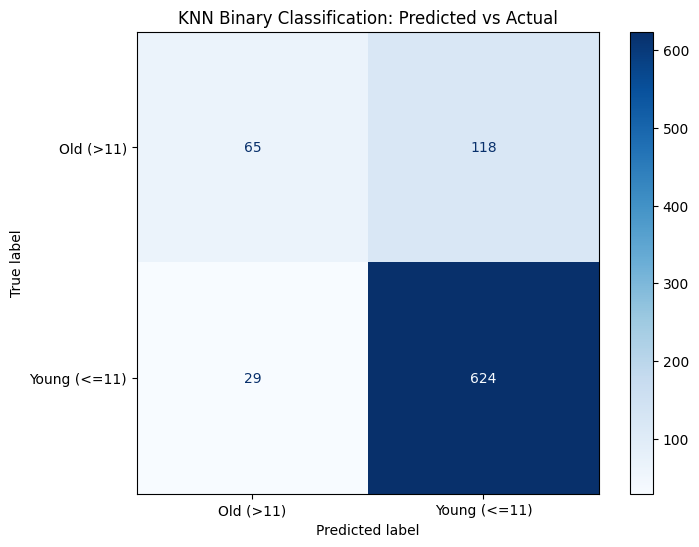

In [55]:
# @title
# --- KNN BINARY CLASSIFICATION BLOCK ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Target Definition (Matching MLP Setup) [cite: 496, 497]
# Young: rings <= 11; Old: rings > 11 [cite: 498, 499]
# Note: Since y_train/y_test are based on Age (Rings + 1.5), 11 rings = 12.5 years [cite: 73]
y_train_binary = (y_train <= 12.5).astype(int)
y_test_binary = (y_test <= 12.5).astype(int)

# 2. KNN Classifier Definition
# Using the optimized parameters found during your GridSearch [cite: 205]
knn_binary = KNeighborsClassifier(
    n_neighbors=18,
    weights='distance',
    p=1 # Manhattan distance
)

# 3. Create and Fit Pipeline
# Uses your existing 'preprocess' ColumnTransformer [cite: 138, 149]
class_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", knn_binary)
])

class_pipe.fit(X_train, y_train_binary)

# 4. Model Evaluation
y_pred_binary = class_pipe.predict(X_test)
y_prob_binary = class_pipe.predict_proba(X_test)

# Calculate metrics for comparison with MLP
acc = accuracy_score(y_test_binary, y_pred_binary)
loss = log_loss(y_test_binary, y_prob_binary)

print("=== KNN BINARY CLASSIFICATION METRICS ===")
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss (Binary Crossentropy): {loss:.4f}")

# 5. Visual Comparison (Confusion Matrix)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_binary,
    y_pred_binary,
    display_labels=['Old (>11)', 'Young (<=11)'],
    cmap='Blues',
    ax=ax
)
plt.title("KNN Binary Classification: Predicted vs Actual")
plt.show()